<a href="https://colab.research.google.com/github/aisyahbelajar/Analisis-sentiment-film-merah-putih-one-for-all/blob/main/with_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crawl Data Twitter




In [31]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [12]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

for fn in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[fn]), encoding='latin-1')
    display(df.head())

Saving merahputih_download.csv to merahputih_download (1).csv


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.960000e+18,Tue Aug 19 23:50:41 +0000 2025,0,@deaawaliaa Kecewa berat Kak Ci Dea nggak Nont...,1.960000e+18,NaN,deaawaliaa,in,NaN,0,0,0,https://x.com/undefined/status/195795339784561...,1.945672e+09,NaN
1,1.960000e+18,Tue Aug 19 23:40:56 +0000 2025,0,@ismedBadjeber Halo! Berdasarkan data terbaru ...,1.960000e+18,NaN,ismedBadjeber,in,NaN,0,1,0,https://x.com/undefined/status/195795094219800...,1.720000e+18,NaN
2,1.960000e+18,Tue Aug 19 23:38:35 +0000 2025,1,Hi @grok berapa jumlah penonton Film Merah Put...,1.960000e+18,NaN,NaN,in,NaN,0,1,0,https://x.com/undefined/status/195795035303670...,1.858973e+08,NaN
3,1.960000e+18,Tue Aug 19 23:24:08 +0000 2025,0,Skenario konspirasi Film Merah Putih : One for...,1.960000e+18,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195794671464999...,1.425293e+09,NaN
4,1.960000e+18,Tue Aug 19 23:17:10 +0000 2025,0,Masalah kualitas film animasi merah putih one ...,1.960000e+18,https://pbs.twimg.com/media/GywEj0_aIAAO27E.jpg,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195794496182933...,1.520000e+18,NaN


Pre Processing Data

In [18]:
# Buat kolom clean_text
def clean_text(text):
    text = text.lower()  # jadi huruf kecil semua
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # hapus URL
    text = re.sub(r"@\w+", "", text)  # hapus mention
    text = re.sub(r"#\w+", "", text)  # hapus hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus tanda baca & angka
    text = re.sub(r"\s+", " ", text).strip()  # hapus spasi berlebih
    return text

df['clean_text'] = df['full_text'].apply(clean_text)

# Cek hasilnya
df[['full_text', 'clean_text']].head()


,full_text,clean_text
0,@Ferari_77 KAYA POSTER MERAH PUTIH ONE FOR ALL...,kaya poster merah putih one for all ajg nanngi...
1,@KevinDota4 @ARSIPAJA Film Merah Putih: One fo...,film merah putih one for all memang kontrovers...
2,@ARSIPAJA ayo kita dukung merah putih film one...,ayo kita dukung merah putih film one for all s...
3,Dihujat Publik Sutradara 'Merah Putih: One for...,dihujat publik sutradara merah putih one for a...
4,pengen nonton merah putih one for all salah be...,pengen nonton merah putih one for all salah be...


Labeling Data BERT

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Buat pipeline sentiment
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [21]:
def bert_label(text):
    result = sentiment_analyzer(text)[0]  # result = {'label': '5 stars', 'score': 0.85}
    label = result['label']

    # Mapping ke 3 kelas sederhana: 0=negatif, 1=positif, 2=netral
    if label in ['1 star', '2 stars']:
        return 0  # negatif
    elif label == '3 stars':
        return 2  # netral
    else:
        return 1  # positif

df['sentiment'] = df['clean_text'].apply(bert_label)


In [22]:
df[['clean_text', 'sentiment']].head(10)


,clean_text,sentiment
0,kaya poster merah putih one for all ajg nanngi...,1
1,film merah putih one for all memang kontrovers...,0
2,ayo kita dukung merah putih film one for all s...,0
3,dihujat publik sutradara merah putih one for a...,0
4,pengen nonton merah putih one for all salah be...,1
5,mau dongeng merah putih one for all,1
6,merah putih one for all dong omm,1
7,muak sm film animasi indonesia merah putih one...,0
8,ehh aku kira nonton merah putih one for all ba...,0
9,mnding nnton merah putih one for all,1


TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']


SMOTE

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


Classification with Random Forest

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [26]:
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        86
           1       0.74      0.83      0.78        82
           2       0.96      0.90      0.93        72

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.82      0.82      0.82       240

Confusion Matrix:
[[63 20  3]
 [14 68  0]
 [ 3  4 65]]


Visualization

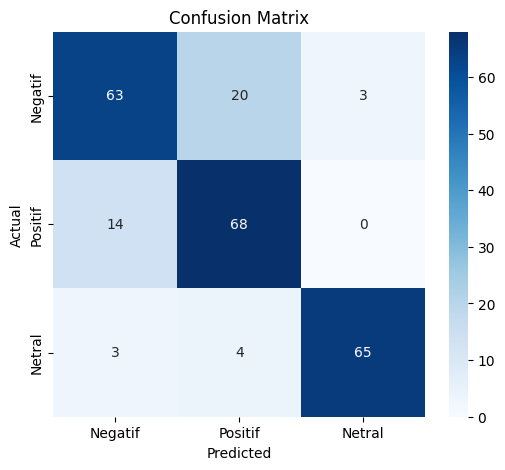

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


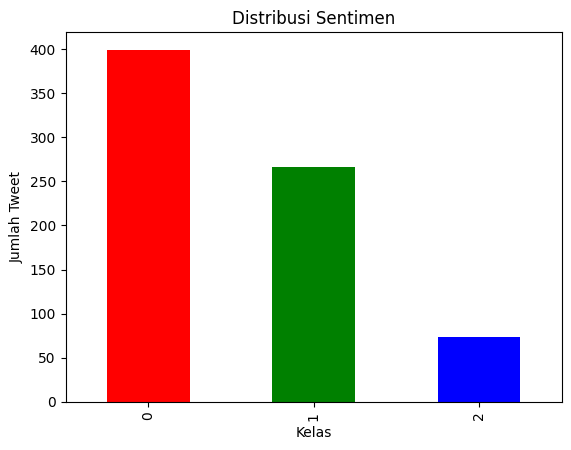

In [33]:
df['sentiment'].value_counts().plot(kind='bar', color=['red','green','blue'])
plt.title("Distribusi Sentimen")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Tweet")
plt.show()


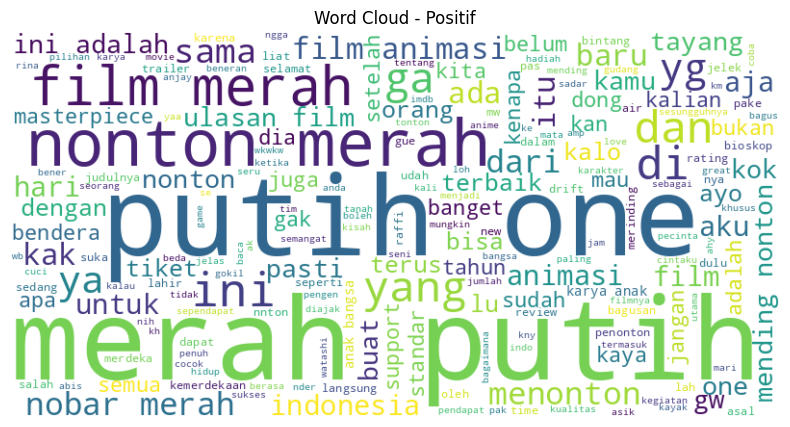

In [37]:
text = " ".join(df[df['sentiment']==1]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positif")
plt.show()


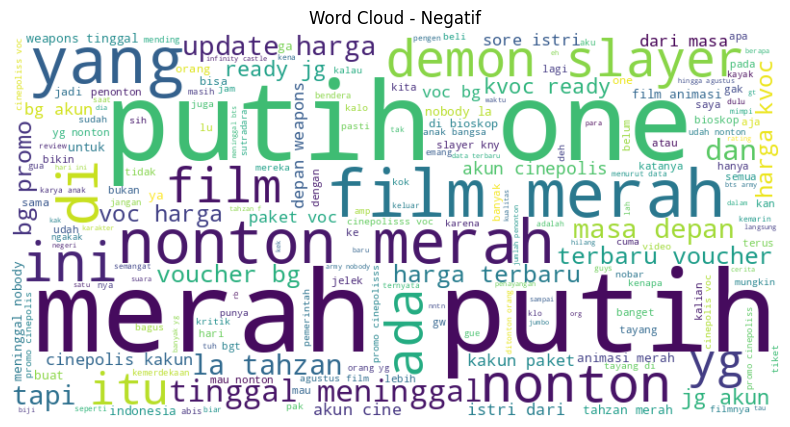

In [36]:
text_neg = " ".join(df[df['sentiment']==0]['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(text_neg)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negatif")
plt.show()


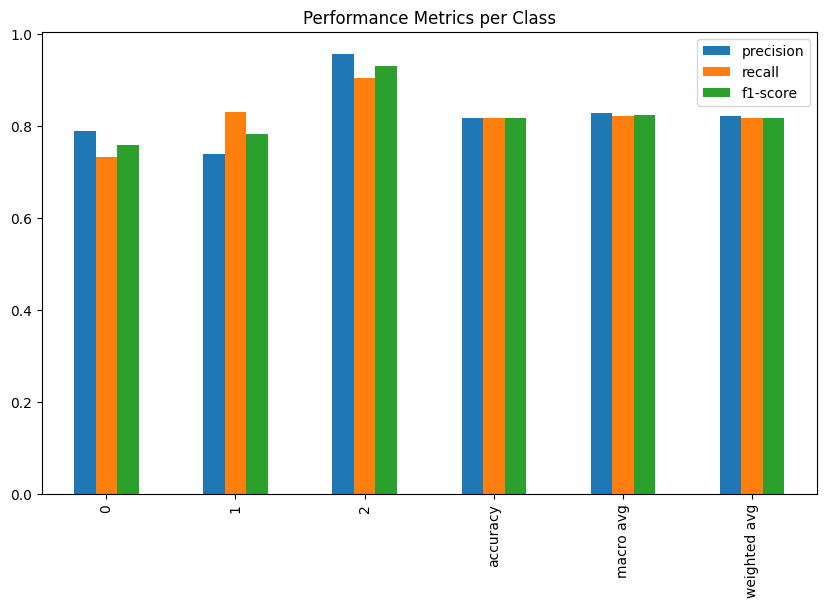

In [34]:
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df[['precision','recall','f1-score']].plot(kind='bar', figsize=(10,6))
plt.title("Performance Metrics per Class")
plt.show()
